In [1]:
import datetime
import itertools
import json
import pickle
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy

from collections import Counter
from google.cloud import bigquery
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Loading data from BQ**

As I do not have PyCharm Pro I was not allowed to run jupyter notebooks so in order to keep the notebook format I used Google Colab.
However when using Colab I need extra permimssions and the query you sent did not work.
You can see the error I got below.
So, basically what I did was run the query to connect to the db from a script and save the db in a csv and then import the csv to colab.

In [2]:
client_bq = bigquery.Client.from_service_account_json("credentials.json", project='charged-dialect-824')

def load_bq_data(_sql):
    _df = client_bq.query(_sql).to_dataframe()
    return _df

sql = """
SELECT *
FROM RicardoInterview.product_detection_training_data
"""

df = load_bq_data(sql)

FileNotFoundError: ignored

In [3]:
# These are the real lines I used to import the csv to Colab.
# Unless you are using Colab you do not really need them as you can import the db from the previous cells.

'''
from google.colab import files
uploaded = files.upload()

# borrar
import io
df = pd.read_csv(io.BytesIO(uploaded['df_test.csv'])) '''


Saving df_test.csv to df_test.csv


In [4]:
len(df)

37567

In [5]:
df.head()

,Unnamed: 0,articleId,title,subtitle,productType
0,0,-3393892867263864215,Gone Is Gone - Echolocation,Gone Is Gone - Echolocation,cd
1,1,-2831118468819601923,Ekseption-The Lost Last Concert Tapes...,The Lost Last Concert Tapes (Box-Set),cd
2,2,6835807414137785977,PORTISHEAD CD-Sammlung 3 CDs #16,Kollektion für Fans der Trip-Hop-Pioniere aus ...,cd
3,3,-4912458353746230865,Primeon CD-R Rohlinge (bunt),39 Stück auf der Spindel,cd
4,4,1496864991301777371,Adonia - Zmittst im Füür,Markus Hottiger / Markus Heusser,cd


**Remove duplicated articles**


In [6]:
print(f'Our df contains {df.shape[0]} rows\n')
print(f'There are {df[df.duplicated("articleId", keep=False)].shape[0]} duplicated rows\n')
df.drop_duplicates(subset='articleId', keep='first', inplace=True)
print(f'After removing duplicates our df contains {df.shape[0]} rows\n')

Our df contains 37567 rows

There are 991 duplicated rows

After removing duplicates our df contains 37032 rows



**Check null values**

In [7]:
print(f'Columns that contain nulls: {df.isna().any()}\n')
print('There are null values in the title and subtitle columns, we are gonna remove rows where both columns are null\n')
df.dropna(subset=['title', 'subtitle'], how='all', inplace=True)
print(f'After removing null rows our df contains {df.shape[0]} rows\n')
print(f'Now we only have null values in the subtitle column. {df.isna().any()}\n')
print(f'The percentage of null values for the subtitle column is: {round((df[df.columns[df.isnull().any()]].isnull().sum() * 100 / df.shape[0]).values[0],1)}%\n')

Columns that contain nulls: Unnamed: 0     False
articleId      False
title           True
subtitle        True
productType    False
dtype: bool

There are null values in the title and subtitle columns, we are gonna remove rows where both columns are null

After removing null rows our df contains 37030 rows

Now we only have null values in the subtitle column. Unnamed: 0     False
articleId      False
title          False
subtitle        True
productType    False
dtype: bool

The percentage of null values for the subtitle column is: 56.7%



In [8]:
# Some fo the subtitles do not seem to add a lot of information about the product, we are gonna check which ones are repeated among several produc type and we are gonna remove them
print(f'Number of entities in subtitle column: {len(set(df["subtitle"]))}')
remove_expressions = []
for i in set(df['subtitle']):
  if len(set(df[df['subtitle']==i]['productType'])) > 1:
    remove_expressions.append(i)
print(f'Number of entities to remove from subtitle: {len(remove_expressions)}')
df['clean_subtitle'] = df['subtitle'].apply(lambda x: ' ' if x in remove_expressions else x)

Number of entities in subtitle column: 13224
Number of entities to remove from subtitle: 208


In [9]:
# With such a big percentage I think it is better to merge both columns, title and subtitle into one called merged titles
df = df.fillna('')
df['merged_titles'] = df['title'] + ' ' + df['clean_subtitle']
df.head()

,Unnamed: 0,articleId,title,subtitle,productType,clean_subtitle,merged_titles
0,0,-3393892867263864215,Gone Is Gone - Echolocation,Gone Is Gone - Echolocation,cd,Gone Is Gone - Echolocation,Gone Is Gone - Echolocation Gone Is Gone - Ech...
1,1,-2831118468819601923,Ekseption-The Lost Last Concert Tapes...,The Lost Last Concert Tapes (Box-Set),cd,The Lost Last Concert Tapes (Box-Set),Ekseption-The Lost Last Concert Tapes... The L...
2,2,6835807414137785977,PORTISHEAD CD-Sammlung 3 CDs #16,Kollektion für Fans der Trip-Hop-Pioniere aus ...,cd,Kollektion für Fans der Trip-Hop-Pioniere aus ...,PORTISHEAD CD-Sammlung 3 CDs #16 Kollektion fü...
3,3,-4912458353746230865,Primeon CD-R Rohlinge (bunt),39 Stück auf der Spindel,cd,39 Stück auf der Spindel,Primeon CD-R Rohlinge (bunt) 39 Stück auf der ...
4,4,1496864991301777371,Adonia - Zmittst im Füür,Markus Hottiger / Markus Heusser,cd,Markus Hottiger / Markus Heusser,Adonia - Zmittst im Füür Markus Hottiger / Mar...


**Check if the tags are balanced**

In [10]:
print(f'Number of tags: {len(set(df["productType"]))}\n')
print(f'Number of courrences per tag: {df["productType"].value_counts()}\n')
print(f'{round(len(set(df.groupby("productType").filter(lambda x: len(x) == 99)["productType"]))/len(set(df["productType"]))*100,1)}% of tags have 99 occurances that is the maximum\n')
print(f'Number of tags that have less than 90 occurrences: {len(set(df.groupby("productType").filter(lambda x: len(x) < 90)["productType"]))}\n')
print(f'Number of tags that have less than 50 occurrences: {len(set(df.groupby("productType").filter(lambda x: len(x) < 50)["productType"]))}\n')

Number of tags: 383

Number of courrences per tag: cd            99
trailer       99
mattress      99
massager      99
magazine      99
              ..
holster       59
handrail      59
jukebox       59
dump_truck    51
marble        46
Name: productType, Length: 383, dtype: int64

61.6% of tags have 99 occurances that is the maximum

Number of tags that have less than 90 occurrences: 26

Number of tags that have less than 50 occurrences: 1



Some of the tag are unde representd so we should keep this in mind when selecting the evaluation me tric, we will use F1 which is more appropiate for this type of data.
If this does not give good results we can try to oversample the data (upsample the minority class) howveer duplicating data does not always add any new information to the model.


**Cleaning: lowercasing, replacing special characters, removing numbers**

In [11]:
df['merged_titles'] = df['merged_titles'].str.lower() # lowercasing
df['merged_titles'] = df['merged_titles'].apply(lambda x: re.sub('-', '- ', str(x))) # add space after -
df['merged_titles'] = df['merged_titles'].apply(lambda x: re.sub(r'[^\w\s+\']+', '', str(x))) # remove special characters
df['merged_titles'] = df['merged_titles'].apply(lambda x: re.sub('/', '', x)) # remove / character
df['merged_titles'] = df['merged_titles'].apply(lambda x:' '.join(x.split())) # remove extra spacing
df['merged_titles'] = df['merged_titles'].apply(lambda x:''.join([i for i in x if not i.isdigit()])) # remove numbers

**Tokenization**

In [12]:
df['merged_titles_tokenize'] = df['merged_titles'].apply(word_tokenize) #nltk tokenization by word
df.head()

,Unnamed: 0,articleId,title,subtitle,productType,clean_subtitle,merged_titles,merged_titles_tokenize
0,0,-3393892867263864215,Gone Is Gone - Echolocation,Gone Is Gone - Echolocation,cd,Gone Is Gone - Echolocation,gone is gone echolocation gone is gone echoloc...,"[gone, is, gone, echolocation, gone, is, gone,..."
1,1,-2831118468819601923,Ekseption-The Lost Last Concert Tapes...,The Lost Last Concert Tapes (Box-Set),cd,The Lost Last Concert Tapes (Box-Set),ekseption the lost last concert tapes the lost...,"[ekseption, the, lost, last, concert, tapes, t..."
2,2,6835807414137785977,PORTISHEAD CD-Sammlung 3 CDs #16,Kollektion für Fans der Trip-Hop-Pioniere aus ...,cd,Kollektion für Fans der Trip-Hop-Pioniere aus ...,portishead cd sammlung cds kollektion für fa...,"[portishead, cd, sammlung, cds, kollektion, fü..."
3,3,-4912458353746230865,Primeon CD-R Rohlinge (bunt),39 Stück auf der Spindel,cd,39 Stück auf der Spindel,primeon cd r rohlinge bunt stück auf der spindel,"[primeon, cd, r, rohlinge, bunt, stück, auf, d..."
4,4,1496864991301777371,Adonia - Zmittst im Füür,Markus Hottiger / Markus Heusser,cd,Markus Hottiger / Markus Heusser,adonia zmittst im füür markus hottiger markus ...,"[adonia, zmittst, im, füür, markus, hottiger, ..."


**Visualization**

In [13]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('german'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1

    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:20]
    x,y=zip(*top)
    plt.figure(figsize=(10,5))
    plt.bar(x,y)

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('german'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    plt.figure(figsize=(10,5))
    plt.bar(x,y)
    plt.xticks(rotation = 90)

Top 20 Stop words present in our titles

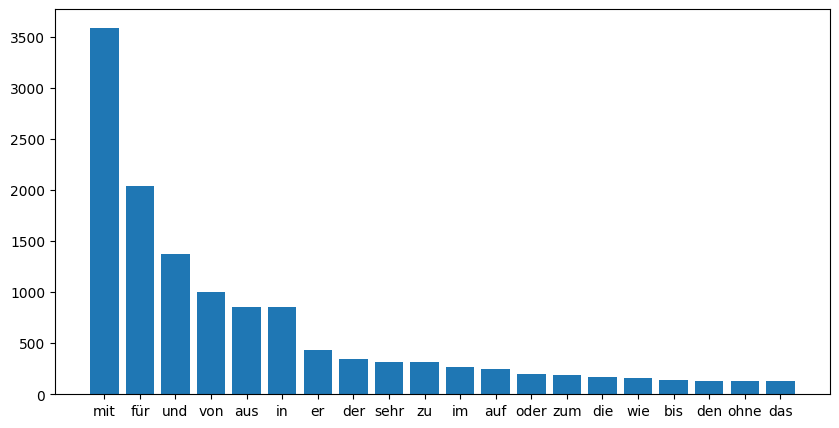

In [14]:
plot_top_stopwords_barchart(df['merged_titles'])

Top 20 words different from stop words present in our titles

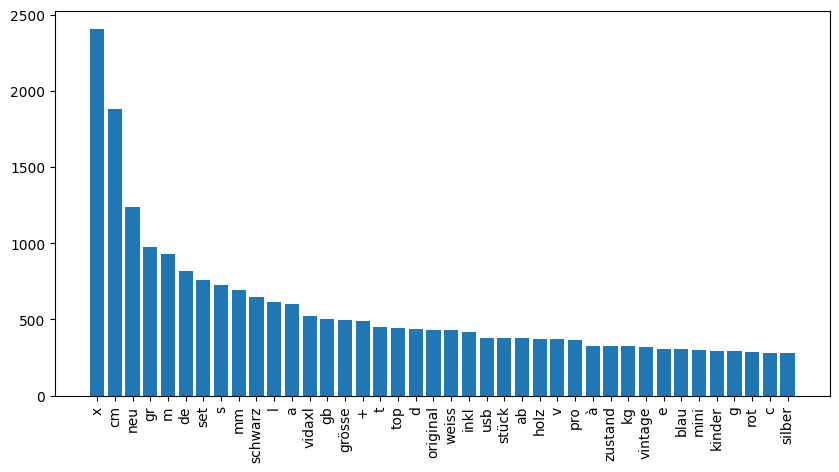

In [15]:
plot_top_non_stopwords_barchart(df['merged_titles'])

In [16]:
extra_list = ['nan', 'x', 'cm', 'neu', 'm', 'mm', 'gr', 'de', 's', 'inkl', 'l', 'top', 'original',
              'zustand', 'ab', 'gb', 'à', 'd', 'pro', 'kg', 'lieferung'] # Additional stopwords
stop_words = set(stopwords.words('german')) # german stop words
english_words = set(stopwords.words('english')) # some titles are in english
french_words = set(stopwords.words('french')) # some titles are in french
stop_words.update(extra_list)
stop_words.update(english_words)
stop_words.update(french_words)

In [17]:
# Remove stopwords

df['merged_titles_tokenize'] = df['merged_titles_tokenize'].apply(lambda x: [word for word in x if word not in stop_words])

df.head()

,Unnamed: 0,articleId,title,subtitle,productType,clean_subtitle,merged_titles,merged_titles_tokenize
0,0,-3393892867263864215,Gone Is Gone - Echolocation,Gone Is Gone - Echolocation,cd,Gone Is Gone - Echolocation,gone is gone echolocation gone is gone echoloc...,"[gone, gone, echolocation, gone, gone, echoloc..."
1,1,-2831118468819601923,Ekseption-The Lost Last Concert Tapes...,The Lost Last Concert Tapes (Box-Set),cd,The Lost Last Concert Tapes (Box-Set),ekseption the lost last concert tapes the lost...,"[ekseption, lost, last, concert, tapes, lost, ..."
2,2,6835807414137785977,PORTISHEAD CD-Sammlung 3 CDs #16,Kollektion für Fans der Trip-Hop-Pioniere aus ...,cd,Kollektion für Fans der Trip-Hop-Pioniere aus ...,portishead cd sammlung cds kollektion für fa...,"[portishead, cd, sammlung, cds, kollektion, fa..."
3,3,-4912458353746230865,Primeon CD-R Rohlinge (bunt),39 Stück auf der Spindel,cd,39 Stück auf der Spindel,primeon cd r rohlinge bunt stück auf der spindel,"[primeon, cd, r, rohlinge, bunt, stück, spindel]"
4,4,1496864991301777371,Adonia - Zmittst im Füür,Markus Hottiger / Markus Heusser,cd,Markus Hottiger / Markus Heusser,adonia zmittst im füür markus hottiger markus ...,"[adonia, zmittst, füür, markus, hottiger, mark..."


**Stemming**

In [18]:
stemmer = SnowballStemmer("german")
df['stemmed'] = df['merged_titles_tokenize'].apply(lambda x: [stemmer.stem(y) for y in x])
df['stemmed_join'] = [' '.join(map(str, l)) for l in df['stemmed']]
df.head()

,Unnamed: 0,articleId,title,subtitle,productType,clean_subtitle,merged_titles,merged_titles_tokenize,stemmed,stemmed_join
0,0,-3393892867263864215,Gone Is Gone - Echolocation,Gone Is Gone - Echolocation,cd,Gone Is Gone - Echolocation,gone is gone echolocation gone is gone echoloc...,"[gone, gone, echolocation, gone, gone, echoloc...","[gon, gon, echolocation, gon, gon, echolocation]",gon gon echolocation gon gon echolocation
1,1,-2831118468819601923,Ekseption-The Lost Last Concert Tapes...,The Lost Last Concert Tapes (Box-Set),cd,The Lost Last Concert Tapes (Box-Set),ekseption the lost last concert tapes the lost...,"[ekseption, lost, last, concert, tapes, lost, ...","[ekseption, lost, last, concert, tap, lost, la...",ekseption lost last concert tap lost last conc...
2,2,6835807414137785977,PORTISHEAD CD-Sammlung 3 CDs #16,Kollektion für Fans der Trip-Hop-Pioniere aus ...,cd,Kollektion für Fans der Trip-Hop-Pioniere aus ...,portishead cd sammlung cds kollektion für fa...,"[portishead, cd, sammlung, cds, kollektion, fa...","[portishead, cd, sammlung, cds, kollektion, fa...",portishead cd sammlung cds kollektion fan trip...
3,3,-4912458353746230865,Primeon CD-R Rohlinge (bunt),39 Stück auf der Spindel,cd,39 Stück auf der Spindel,primeon cd r rohlinge bunt stück auf der spindel,"[primeon, cd, r, rohlinge, bunt, stück, spindel]","[primeon, cd, r, rohling, bunt, stuck, spindel]",primeon cd r rohling bunt stuck spindel
4,4,1496864991301777371,Adonia - Zmittst im Füür,Markus Hottiger / Markus Heusser,cd,Markus Hottiger / Markus Heusser,adonia zmittst im füür markus hottiger markus ...,"[adonia, zmittst, füür, markus, hottiger, mark...","[adonia, zmitt, fuur, markus, hottig, markus, ...",adonia zmitt fuur markus hottig markus heuss


**Data Vectorization**

In [19]:
# transform categorical taget into numerical
target = pd.factorize(df['productType'])
df['target'] = target[0]

In [20]:
# split train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['stemmed_join'], df['target'], random_state=0)

In [21]:
# vectorizing data
transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer()
# fit train data to the count vectorizer
counts = count_vectorizer.fit_transform(X_train.values)
counts_test = count_vectorizer.transform(X_test.values)
# fit the ngrams count to the tfidf transformer
df_train = transformer.fit_transform(counts)
df_test = transformer.transform(counts_test)

**Model training with cross validation**

In [23]:
Extr = ExtraTreesClassifier()
grid_Extr = {"n_estimators": [5, 10, 20]}
gs_Extr = GridSearchCV(Extr,
                       grid_Extr,
                       cv=10,
                       scoring='f1_weighted',
                       verbose=1,
                       n_jobs=-1)

gs_Extr.fit(df_train, y_train)

print(f'Extra Tree Classifier best parameters: {gs_Extr.best_params_}, Extra Tree Classifier forest best score: {gs_Extr.best_score_}')
print('F1 score of ExtraTrees classifier on train set: {:.2f}'.format(f1_score(y_train, gs_Extr.predict(df_train), average='weighted')))
print('F1 score of ExtraTrees classifier on test set: {:.2f}'.format(f1_score(y_test, gs_Extr.predict(df_test), average='weighted')))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Extra Tree Classifier best parameters: {'n_estimators': 20}, Extra Tree Classifier forest best score: 0.6850512466182684
F1 score of ExtraTrees classifier on train set: 1.00
F1 score of ExtraTrees classifier on test set: 0.69


In [24]:
RandomFC = RandomForestClassifier()
grid_RandomFC = {"n_estimators": [5, 10, 20,50]}
gs_RandomFC = GridSearchCV(RandomFC,
                                grid_RandomFC,
                                cv=10,
                                scoring='f1_weighted',
                                verbose=1,
                                n_jobs=-1)

gs_RandomFC.fit(df_train, y_train)

print(f'Random forest best parameters: {gs_RandomFC.best_params_}, Random forest best score: {gs_RandomFC.best_score_}')
print('F1 score of Random forest classifier on training set: {:.2f}'.format(f1_score(y_train, gs_RandomFC.predict(df_train), average='weighted')))
print('F1 score of Random forest classifier on test set: {:.2f}'.format(f1_score(y_test, gs_RandomFC.predict(df_test), average='weighted')))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Random forest best parameters: {'n_estimators': 50}, Random forest best score: 0.6928389635744834
F1 score of Random forest classifier on training set: 1.00
F1 score of Random forest classifier on test set: 0.69


In [25]:
NB = MultinomialNB()
NB.fit(df_train, y_train)

print('F1 score of NB  classifier on training set: {:.2f}'.format(f1_score(y_train, NB.predict(df_train), average='weighted')))
print('F1 score of NB classifier on test set: {:.2f}'.format(f1_score(y_test, NB.predict(df_test), average='weighted')))

F1 score of NB  classifier on training set: 0.93
F1 score of NB classifier on test set: 0.69


In [26]:
logreg = LogisticRegression()
grid_logreg = {"C": [1, 1e3, 1e5],
               "max_iter": [50, 100],
               "solver": ['saga']
                    }

gs_logreg = GridSearchCV(logreg,
                         grid_logreg,
                         cv=10,
                         scoring='f1_weighted',
                         verbose=1,
                         n_jobs=-1)



gs_logreg.fit(df_train, y_train)

print(f'Logreg classifier best parameters: {gs_logreg.best_params_}, Logreg classifier best score: {gs_logreg.best_score_}')
print('F1 score of Logreg classifier on training set: {:.2f}'.format(f1_score(y_train, gs_logreg.predict(df_train), average='weighted')))
print('F1 score of Logreg classifier on test set: {:.2f}'.format(f1_score(y_test, gs_logreg.predict(df_test), average='weighted')))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logreg classifier best parameters: {'C': 1000.0, 'max_iter': 50, 'solver': 'saga'}, Logreg classifier best score: 0.731934462754541
F1 score of Logreg classifier on training set: 1.00
F1 score of Logreg classifier on test set: 0.74


In [27]:
best_model = gs_logreg.best_estimator_
best_model

LogisticRegression(C=1000.0, max_iter=50, solver='saga')

In [28]:
# let's train the model with all the data set

final_model = Pipeline(steps=[("count_vect",CountVectorizer()),
                       ("tfidf",TfidfTransformer(smooth_idf=False)),
                      ("logreg",LogisticRegression(C=1e5, max_iter = 100, solver = 'saga'))])


final_model.fit(df['stemmed_join'], df['target'])


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('count_vect', CountVectorizer()),
                ('tfidf', TfidfTransformer(smooth_idf=False)),
                ('logreg', LogisticRegression(C=100000.0, solver='saga'))])

In [29]:
# saving model into pickle
with open ("final_model.model", "wb") as file:
    pickle.dump (final_model, file)


In [30]:
# save targets into dict
classes_df = df[['productType', 'target']]
classes_df.drop_duplicates(inplace=True)
classes_dict = dict(zip(classes_df['target'], classes_df['productType']))

tf = open("tags.json", "w")
json.dump(classes_dict,tf)
tf.close()

<ipython-input-30-1818764f34de>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classes_df.drop_duplicates(inplace=True)
